In [1]:
# source: https://nbviewer.org/github/niosus/notebooks/blob/master/icp.ipynb
import sys
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from ranges_and_cartesian import read_scans_write_points

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIG_SIZE = 12
BIGG_SIZE = 14
BIGGER_SIZE = 16

plt.rc('xtick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIG_SIZE)    # fontsize of the tick labels
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Inverse of a CDF related functions

def RationalApproximation(t):
    # Abramowitz and Stegun formula 26.2.23.
    # The absolute value of the error should be less than 4.5 e-4.
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    return t - ((c[2]*t + c[1])*t + c[0]) / (((d[2]*t + d[1])*t + d[0])*t + 1.0)

def NormalCDFInverse(p):
    # See article above for explanation of this section.
    if (p < 0.5):
        # F^-1(p) = - G^-1(p)
        return -RationalApproximation( np.sqrt(-2.0*np.log(p)) )
    else:
        # F^-1(p) = G^-1(1-p)
        return RationalApproximation( np.sqrt(-2.0*np.log(1-p)) ) 

In [4]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=5, markersize_2=5):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

In [5]:
def returnMetric(sum):
    num_points = 180
    laserRangeVaraince = 0.015933206879414907
    normalVariance = 2*laserRangeVaraince
    muHalfNormal = np.sqrt(2 * normalVariance / np.pi)
    varianceHalfNormal = normalVariance * (1 - (2/np.pi))
    metric = (sum - (muHalfNormal*num_points)) / np.sqrt(varianceHalfNormal*num_points)

    return metric

def returnFinites(array):
    arr_isfinite = np.all(np.isfinite(array), axis=1)
    return array[arr_isfinite, :]

In [6]:
# change references to this everywhere
# saveFile = 'data/points_from_sim_ranges_inf.npz' 

In [7]:
readFile = "data_add/logRealSimScanComparision.dat"
saveFile = 'writing_data/pointsRealSimScanComp.npz'

# needs to done once to save the points. for now we have the points
# read_scans_write_points(readFile, saveFile)

diff_points_from_ranges = np.load(saveFile)
dspoints_p1_4x1 = returnFinites(diff_points_from_ranges['points_p1'])
dspoints_p2_4x1 = returnFinites(diff_points_from_ranges['points_p2'])

true_data = dspoints_p1_4x1[:, 0:2].T
moved_data = dspoints_p2_4x1[:, 0:2].T

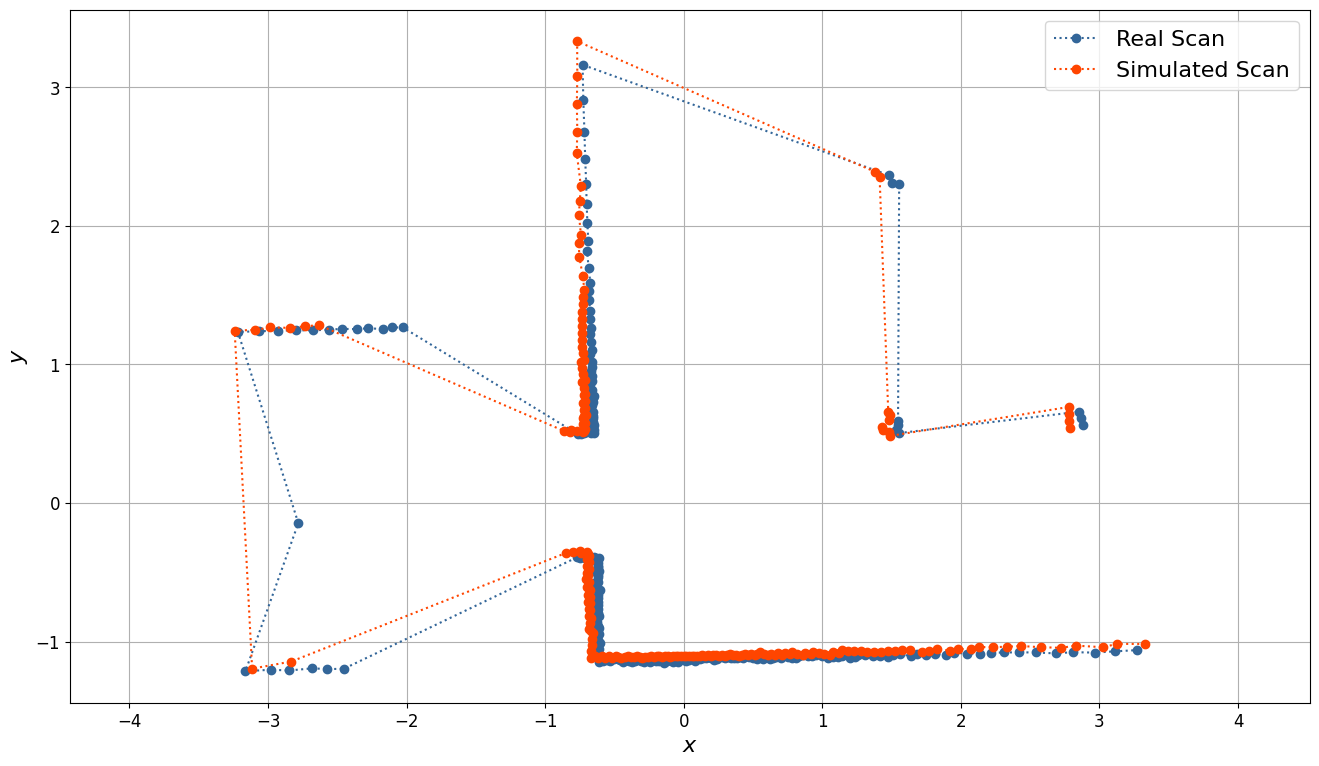

In [8]:
ax = plot_data(true_data, moved_data, 
               label_1='Real Scan', label_2='Simulated Scan',
               markersize_1=6, markersize_2=6)

plt.grid(True)
plt.legend()
plt.show()

In [9]:
# create an initial transformation for ICP to find the original
beta = 0
cos_a = np.cos(beta)
sin_a = np.sin(beta)

fake_trans = np.eye(4)
fake_trans[0:2, 0:2] = np.array([[cos_a, -sin_a],       # rotation matrix
                                 [sin_a, cos_a]])
fake_trans[0, 3] = -0.03                                 # x translation
# fake_trans[1, 3] = 0.3                                  # y translation

In [10]:
# create a point cloud object for open3d and input your points in there
source_pcd = o3d.geometry.PointCloud()
target_pcd = o3d.geometry.PointCloud()
icp_aligned_pcd = o3d.geometry.PointCloud()

source_pcd.points = o3d.utility.Vector3dVector(dspoints_p1_4x1[:, 0:3])
target_pcd.points = o3d.utility.Vector3dVector(dspoints_p2_4x1[:, 0:3])

threshold = 0.02*1e1

In [11]:
# do icp and get the resulting transformation. then transform points according to new transformation

# performing the ICP with open3d
reg_p2p = o3d.pipelines.registration.registration_icp(
            source_pcd, target_pcd, threshold, fake_trans,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

# the final trasnformation as a 4x4 hom. trans.
T_icp = reg_p2p.transformation

# apply transformation to points of p1
points_p1_reg_icp = np.matmul(dspoints_p1_4x1, T_icp.T)
icp_aligned_pcd.points = o3d.utility.Vector3dVector(points_p1_reg_icp[:, 0:3])

print(reg_p2p)
print("Transformation is:")
print(T_icp)
# draw_registration_result(source_pcd, target_pcd, reg_p2p.transformation)

RegistrationResult with fitness=9.619048e-01, inlier_rmse=2.622505e-02, and correspondence_set size of 202
Access transformation to get result.
Transformation is:
[[ 0.99999938 -0.00111568  0.         -0.06519971]
 [ 0.00111568  0.99999938  0.          0.02525456]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


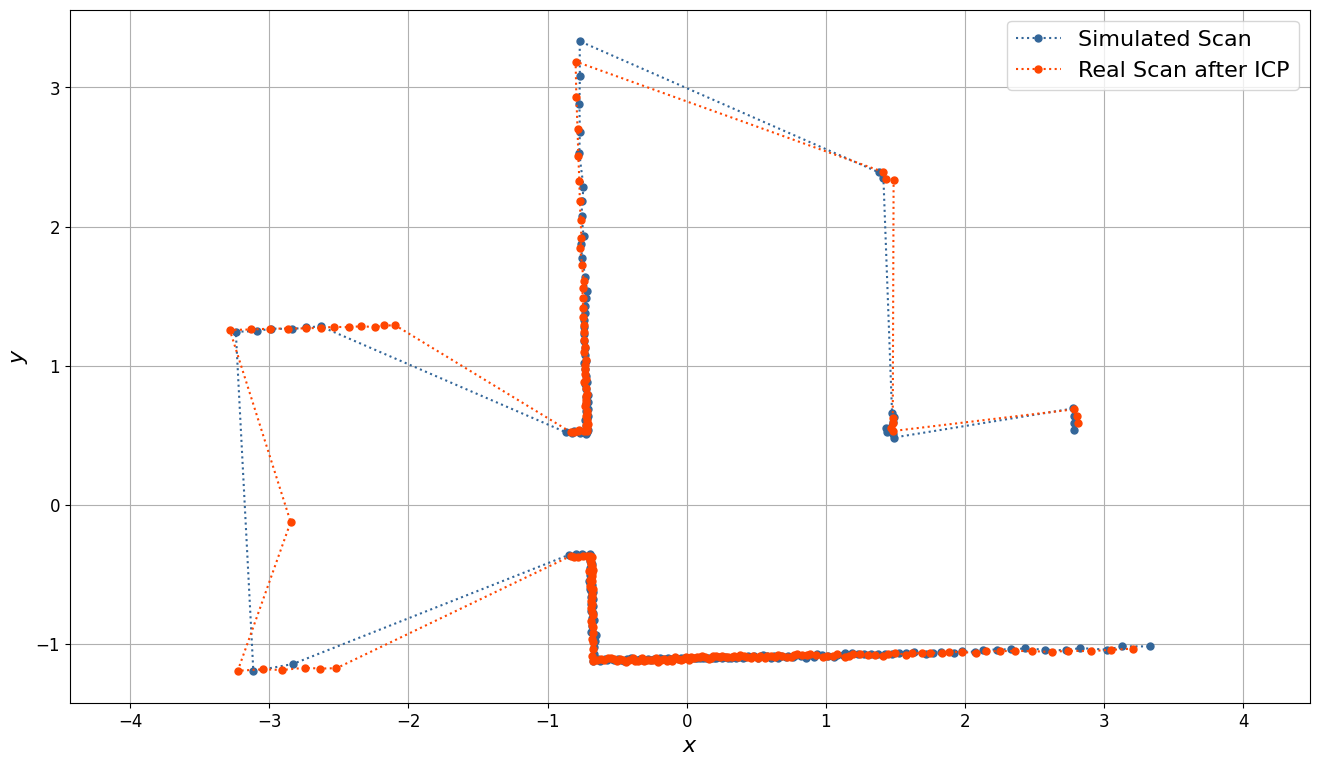

In [12]:
ax = plot_data(moved_data, points_p1_reg_icp[:, 0:2].T, label_1='Simulated Scan', label_2='Real Scan after ICP')

plt.grid(True)
plt.legend()
plt.show()

In [13]:
point_clouds_aligned = "writing_data/pointsSimAlignedReal_2023-06-12-16-36.npz"
np.savez(point_clouds_aligned, points_p1=dspoints_p2_4x1, points_p2=points_p1_reg_icp)

In [14]:
# computing corresponding distance between the two aligned scans
dist_bw_source_target = np.array(source_pcd.compute_point_cloud_distance(target_pcd))
dist_bw_source_target_rw = np.array(target_pcd.compute_point_cloud_distance(source_pcd))
print("Before alignment: ", dist_bw_source_target.sum(), dist_bw_source_target_rw.sum())

dist_bw_target_alined = np.array(target_pcd.compute_point_cloud_distance(icp_aligned_pcd))
dist_bw_target_alined_rw = np.array(icp_aligned_pcd.compute_point_cloud_distance(target_pcd))
print("After alignment: ", dist_bw_target_alined.sum(), dist_bw_target_alined_rw.sum())

Before alignment:  13.02726252594184 9.299908368817023
After alignment:  3.949225903181473 7.191933789358232


In [16]:
sum_st = dist_bw_target_alined.sum()
sum_st_rw = dist_bw_target_alined_rw.sum()
print("Sum of the distances: ", sum_st, sum_st_rw)

Sum of the distances:  3.949225903181473 7.191933789358232


In [17]:
alpha = 0.1
oneMinusAlpha = 1 - alpha
f_inv = NormalCDFInverse(oneMinusAlpha)

print("Metric: ", returnMetric(sum_st))
print("Metric: ", returnMetric(sum_st_rw))
print("F^-1(1-alpha): ", f_inv)
# print(NormalCDFInverse(alpha))

Metric:  -15.022617958652614
Metric:  -12.776542547280009
F^-1(1-alpha):  1.281728756502709
